# Workspace \#3: ``astro.py``

In [1]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [1]:
from random import random

import sys
sys.path.insert(0, '../')

import constants as ct
import particle as pt
import astro as ap

In [3]:
# The contents of astro.py
dir(ap)

['AdiabaticErrorMssg',
 'FreeErrorMssg',
 'Galactic',
 'HEALPix',
 'L_adiab',
 'L_eff',
 'L_free',
 'L_source',
 'L_thy',
 'P_noise',
 'P_signal',
 'SKA_exper_nu',
 'SKA_specs',
 'S_cygA',
 'SkyCoord',
 'Snu_supp',
 'T_noise',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'alpha_from_gamma',
 'bg_408_temp',
 'bisect',
 'brentq',
 'crossings',
 'ct',
 'dimless_adiab',
 'dimless_free',
 'dimless_lum',
 'division',
 'erf',
 'exp',
 'flux',
 'flux_density_to_psd',
 'fsolve',
 'ftt',
 'gamma_from_alpha',
 'getargspec',
 'hp',
 'irrad',
 'lambertw',
 'log',
 'log10',
 'np',
 'nu_factor',
 'os',
 'pars_always',
 'pars_early',
 'pars_late',
 'pars_lightcurve',
 'pars_required',
 'pi',
 'power',
 'psd_to_flux_density',
 'r_to_gal',
 'rho_MW',
 'rho_NFW',
 'sandwich_logeqn',
 'source_id',
 'source_input',
 'sqrt',
 't_arr_default',
 'tage_compute',
 'theta_gal_ctr',
 'trapz']

In [4]:
# parameters required for each astro model. The keys are of the form (model, missing_parameter), for a fixed lightcurve model ('eff'/'thy') and a given missing parameter. The values are then the parameters that need to be known and passed in order to compute the lightcurve. Essentially, the missing parameter is computed based on all the others.

ap.pars_required

{('eff', 'L_peak'): ['t_peak', 'gamma', 't_trans', 't_age', 'L_today'],
 ('eff', 'L_today'): ['L_peak', 't_peak', 'gamma', 't_trans', 't_age'],
 ('eff', 't_age'): ['L_peak', 't_peak', 'gamma', 't_trans', 'L_today'],
 ('eff', 't_trans'): ['L_peak', 't_peak', 'gamma', 'L_today', 't_age'],
 ('thy', 'L_norm'): ['K2',
  'beta',
  'delta',
  't_trans',
  'gamma',
  't_age',
  'L_today'],
 ('thy', 'L_today'): ['L_norm',
  'K2',
  'beta',
  'delta',
  't_trans',
  'gamma',
  't_age']}

## **NOTA BENE:**

### When using either of the spectral luminosities (at peak day, $L_{\rm peak, \, \nu}$; and today, $L_{\rm today, \, \nu}$) to compute the lightcurve, make sure they are evaluated **at the same frequency $\nu$, which _must_ be the pivot frequency $\nu_{\rm pivot}$**. Otherwise, the lighcturve is inconsistent.

Testing that different approaches to the lightcurve models give the same results:

## 1. Lightcurve

### 1.1 Exact (numeric)

In [5]:
# compute lightcurve for different models and approaches
t_peak = 100. # [days] # DO NOT CHANGE IN ORDER TO COMPARE
t_age = 300. # [years]
t_trans = 1. # [years] # DO NOT CHANGE IN ORDER TO COMPARE
t_arr = np.array([t_peak/365., t_trans, t_age]) # [years]

# doing 'eff'

L_peak = 1.e28

source_input = []
approach = []

approach.append('missing L_today')
source_input.append(('eff', {'L_peak':L_peak, 't_peak':t_peak, 'gamma':1., 't_trans':t_trans, 't_age':t_age}))

L_today = ap.L_source(t=t_age,
                      model=source_input[0][0],
                      output_pars=False,
                      **source_input[0][1])

approach.append('missing L_peak')
source_input.append(('eff', {'L_today':L_today, 't_age':t_age, 't_peak':t_peak, 'gamma':1., 't_trans':t_trans, 't_age':t_age}))

approach.append('missing t_trans')
source_input.append(('eff', {'L_today':L_today, 'L_peak':L_peak, 't_age':t_age, 't_peak':t_peak, 'gamma':1.}))

approach.append('missing t_age')
source_input.append(('eff', {'L_today':L_today, 'L_peak':L_peak, 't_trans':t_trans, 't_peak':t_peak, 'gamma':1.}))

print "------------------\nMODEL: 'eff'\n------------------\n"

L_fns = {}
for i, val in enumerate(source_input):
    
    model = val[0]
    pars = val[1]
    
    print approach[i]+':'
    print val
    print '\n(time, Lum):', [(t, ap.L_source(t=t,
                                           model=model,
                                           output_pars=False,
                                           **pars)) for t in t_arr]
    print 'pars: ', ap.L_source(t=t_age,
                                model=model,
                                output_pars=True, **pars)[-1], '\n..................\n'


# doing 'thy'
t_check = t_peak # [days]
t_arr = np.array([t_check/365., t_trans, t_age]) # [years]

K2 = 2.4e3 # DO NOT CHANGE IN ORDER TO COMPARE

print "\n------------------\nMODEL: 'thy'\n------------------\n"

approach.append('missing L_norm')
source_input.append(('thy', {'L_today':L_today, 't_age':t_age, 'beta':0.64, 'K2':K2, 'delta':2.82, 'gamma':1., 't_trans':t_trans, 'tau_factor':((1./5.)**-2.1)}))

L_norm = 1.8672956e+29 * (L_today/1.4203781639864318e+25) # DO NOT CHANGE IN ORDER TO COMPARE

approach.append('missing L_today')
source_input.append(('thy', {'L_norm':L_norm, 'beta':0.64, 'K2':K2, 'delta':2.82, 'gamma':1., 't_trans':t_trans, 't_age':t_age, 'tau_factor':((1./5.)**-2.1)}))

for i, val in enumerate(source_input):
    
    model = val[0]
    pars = val[1]
    
    if model != 'thy':
        continue
    
    print approach[i]+':'
    print val
    print '\n(time, Lum):', [(t, ap.L_source(t=t,
                                           model=model,
                                           output_pars=False,
                                           **pars)) for t in t_arr]
    print 'pars: ', ap.L_source(t=t_age,
                                model=model,
                                output_pars=True,
                                **pars)[-1], '\n..................\n'

------------------
MODEL: 'eff'
------------------

missing L_today:
('eff', {'t_trans': 1.0, 't_peak': 100.0, 'L_peak': 1e+28, 't_age': 300.0, 'gamma': 1.0})

(time, Lum): [(0.273972602739726, 1e+28), (1.0, 4.261134491959295e+27), (300.0, 1.4203781639864318e+25)]
pars:  {'L_peak': 1e+28, 'L_ref': 4.261134491959295e+27, 't_trans': 1.0, 'L_today': 1.4203781639864318e+25, 't_peak': 100.0, 't_age': 300.0, 'gamma': 1.0, 't_ref': 1.0} 
..................

missing L_peak:
('eff', {'t_trans': 1.0, 'L_today': 1.4203781639864318e+25, 't_peak': 100.0, 't_age': 300.0, 'gamma': 1.0})

(time, Lum): [(0.273972602739726, 1e+28), (1.0, 4.261134491959295e+27), (300.0, 1.4203781639864318e+25)]
pars:  {'L_peak': array(1.e+28), 'L_ref': 1.4203781639864318e+25, 't_trans': 1.0, 'L_today': 1.4203781639864318e+25, 't_peak': 100.0, 't_age': 300.0, 'gamma': 1.0, 't_ref': 300.0} 
..................

missing t_trans:
('eff', {'t_peak': 100.0, 'L_today': 1.4203781639864318e+25, 'L_peak': 1e+28, 't_age': 300.0, 'ga

Comparing the lightcuarves from different approaches:

/home/buenabad/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


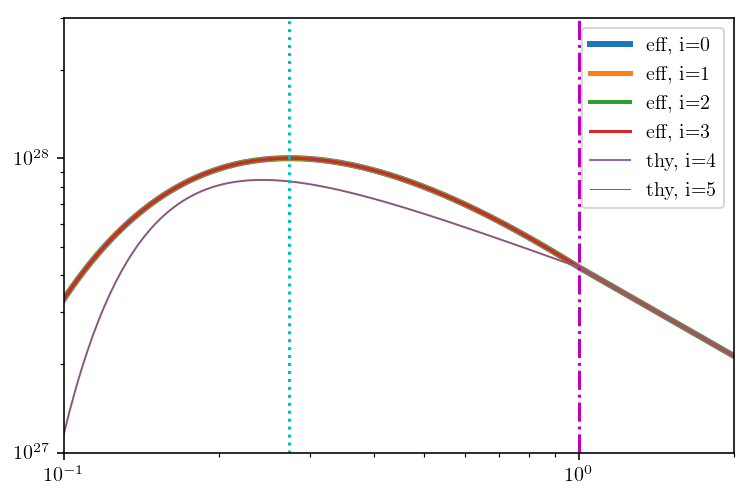

In [6]:
t_arr = np.logspace(log10(1./365), log10(t_age)+0.5, 1001)

max_w = len(source_input)*.5
for i, mod_pars in enumerate(source_input):
    
    model, params = mod_pars
    
    Lfn = lambda tt: ap.L_source(t=tt, model=model, output_pars=False, **params)
    
    plt.loglog(t_arr, Lfn(t_arr), label="{}, i={}".format(model, i), lw=max_w-0.5*i)

plt.axvline(t_age, ls='-', color='k')
plt.axvline(t_trans, ls='-.', color='m')
plt.axvline(t_peak/365, ls=':', color='c')

plt.xlim(0.1, 2.);plt.ylim(1.e27, 3.e28);
# plt.ylim(1.e20, 1.e30);
plt.legend();

Yet another example of lightcurve comparison: Cassiopeia A

{'L_peak': 1e+30, 'L_ref': 3.766367905994918e+25, 't_trans': 32.59251578474538, 'L_today': 3.766367905994918e+25, 't_peak': 100.0, 't_age': 300.0, 'gamma': 2.03, 't_ref': 300.0}
(1001,) (1001,)


True

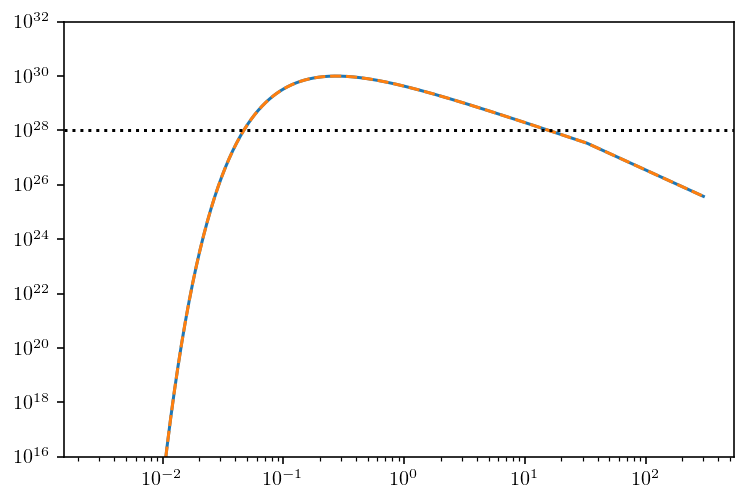

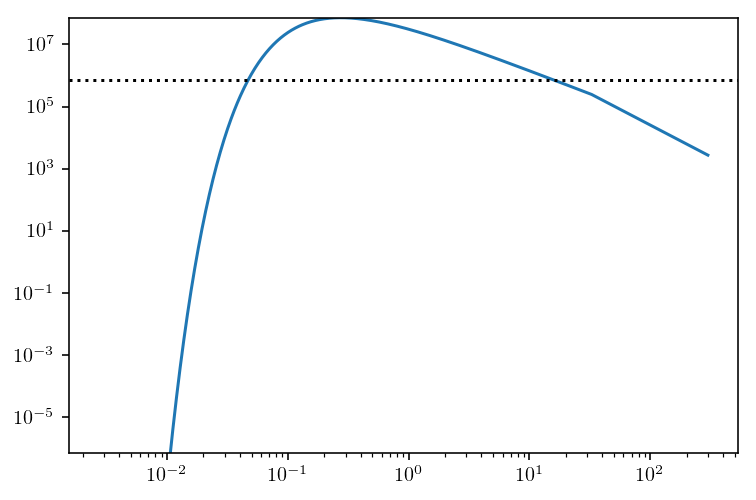

In [9]:
# Cassiopeia A lightcurve

output={}

D = 3.4 # [kpc] Cas A
A = 4.*pi*(D*ct._kpc_over_cm_)**2. # [cm^2] area
SnuCasA = 2723 # [Jy] Cas A

LumCasA = (SnuCasA*ct._Jy_over_cgs_irrad_)*A

source_input = {'longitude':111.734745, # Cas A
                'latitude':-02.129570, # Cas A
                'distance':D, # Cas A
                'size':1.e-6,
                't_age':300., # Cas A
                'alpha':0.77,
                'nu_pivot':1.,
                'gamma':2.03, # Cas A experiment
                'model':'eff', 'L_today':LumCasA, 'L_peak':1.e30,
                't_peak':100.
               }

import echo as ec # temporarily, just to check with the spectral irradiance function in that module
ec.check_source(source_input)

t_arr = np.logspace(log10(1./365), log10(source_input['t_age']), 1001)
t_ref = 1.
nu_arr = np.logspace(-4, 1, 1001)

_, pars = ap.L_source(t_ref,
                      output_pars=True,
                      **source_input)
print pars

t, nu = t_arr, 1.
fac = ap.nu_factor(nu, source_input['nu_pivot'], source_input['alpha'])

Lnu = ap.L_source(t, output_pars=False, **source_input)**fac

Snu = ec.Snu_source(t, nu, source_input, output=output)

print Snu.shape, Lnu.shape

fig_num = int(random()*100)
Area = 4.*pi*(source_input['distance']*ct._kpc_over_cm_)**2.

plt.figure(fig_num)
plt.loglog(t_arr, (Snu*ct._Jy_over_cgs_irrad_)*Area)
plt.loglog(t_arr, Lnu, ls='--')
plt.ylim(1.e16, 1.e32);
plt.axhline(1.e28, c='k', ls=':')

fig_num += 1
plt.figure(fig_num)
plt.loglog(t_arr, Snu)
plt.ylim(1.e16 /(Area*ct._Jy_over_cgs_irrad_), 1.e30 /(Area*ct._Jy_over_cgs_irrad_));
plt.axhline(1.e28 /(Area*ct._Jy_over_cgs_irrad_), c='k', ls=':')

# updating data
ec.Snu_source(t_arr, nu_arr, source_input, output=output)
'source_t-nu-Snu' in output.keys()

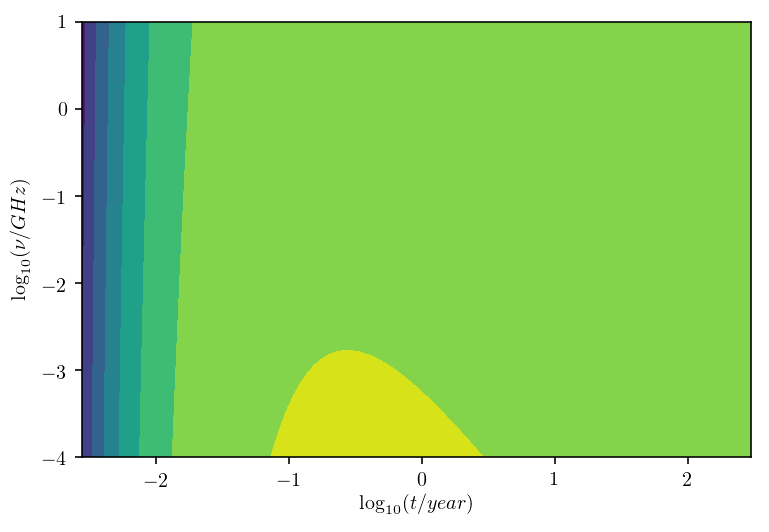

In [10]:
tArr, nuArr, SnuGr = output['source_t-nu-Snu']

plt.contourf(log10(tArr), log10(nuArr), log10(SnuGr))
plt.xlabel(r'$\log_{10}(t/year)$');plt.ylabel(r'$\log_{10}(\nu/GHz)$');

### 1.2 Analytic

``astro.py`` also containts analytic formulas for the lightcurve.

In [9]:
help(ap.Snu_supp)

Help on function Snu_supp in module astro:

Snu_supp(gamma, frac_tpk, frac_tt)
    Fractional suppression of spectral irradiance (i.e. S0/S_peak = L0/L_peak).
    
    Parameters
    ----------
    gamma : adiabatic index
    frac_tpk : ratio of peak day to SNR age
    frac_tt : ratio of transition time to SNR age



In [10]:
help(ap.ftt)

Help on function ftt in module astro:

ftt(gamma, frac_tpk, sup)
    Fractional transition time (i.e. t_trans/t_age).
    
    Parameters
    ----------
    gamma : adiabatic index
    frac_tpk : ratio of peak day to SNR age
    sup : spectral irradiance suppression



In [11]:
help(ap.dimless_free)

Help on function dimless_free in module astro:

dimless_free(frac_tpk, tau)
    Dimensionless free expansion lightcurve.
    
    Parameters
    ----------
    frac_tpk : ratio of peak day to SNR age
    tau : ratio of time to SNR age



In [12]:
help(ap.dimless_adiab)

Help on function dimless_adiab in module astro:

dimless_adiab(gamma, sup, tau)
    Dimensionless adiabatic expansion lightcurve.
    
    Parameters
    ----------
    gamma : adiabatic index
    sup : spectral irradiance suppression
    tau : ratio of time to SNR age



In [13]:
help(ap.dimless_lum)

Help on function dimless_lum in module astro:

dimless_lum(gamma, frac_tpk, sup, tau)
    Dimensionless full lightcurve.
    
    Parameters
    ----------
    gamma : adiabatic index
    frac_tpk : ratio of peak day to SNR age
    sup : spectral irradiance suppression
    tau : ratio of time to SNR age



## 2. Experiment

In [14]:
help(ap.SKA_exper_nu)

Help on function SKA_exper_nu in module astro:

SKA_exper_nu(nu)
    Returns the SKA experiment mode (low/mid) sensitive to the given frequency nu [GHz].
    
    Parameters
    ----------
    nu : frequency [GHz]



In [18]:
print ap.SKA_exper_nu(ct._nu_min_ska_low_*0.9)
print ap.SKA_exper_nu(ct._nu_min_ska_low_*1.1), ap.SKA_exper_nu(ct._nu_max_ska_low_*0.9)
print ap.SKA_exper_nu(ct._nu_min_ska_mid_*1.1), ap.SKA_exper_nu(ct._nu_max_ska_mid_*0.9)
print ap.SKA_exper_nu(ct._nu_max_ska_mid_*1.1)

None
SKA low SKA low
SKA mid SKA mid
None


In [19]:
help(ap.SKA_specs)

Help on function SKA_specs in module astro:

SKA_specs(nu, exper_mode)
    Returns the specifications (area [m^2], window, receiver noise brightness temperature [K]) of the SKA experiment mode, for the given frequency [GHz].
    
    Parameters
    ----------
    nu : frequency [GHz]
    exper_mode : mode in which the experiment is working



In [23]:
print ap.SKA_specs(ct._nu_min_ska_low_*1.1, 'SKA low') # within SKA low detection region
print ap.SKA_specs(ct._nu_min_ska_mid_*1.1, 'SKA mid') # within SKA mid detection region
print ap.SKA_specs(ct._nu_min_ska_mid_*1.1, 'SKA low') # outside SKA low detection region

(419000.0, 1.0, 40.0)
(1000000.0, 1.0, 20.0)
(419000.0, 0.0, 40.0)


## 3. Observation

In [26]:
# background brightness temperature at 408 MHz
ap.bg_408_temp(0., 0.)

725.2261352539062

In [31]:
print ap.T_noise(1., Tr=0.)
print ap.T_noise(1., Tr=10.*np.ones(5))

8.47053053656
[18.47053054 18.47053054 18.47053054 18.47053054 18.47053054]


In [32]:
help(ap.P_noise)

Help on function P_noise in module astro:

P_noise(T_noise, delnu, tobs)
    The power of the noise [eV^2].
    
    Parameters
    ----------
    T_noise: the temperature of the noise [K]
    delnu: the bandwidth of the detector [GHz]
    tobs: the total observation time [hour]



In [33]:
help(ap.P_signal)

Help on function P_signal in module astro:

P_signal(S, A, eta=0.8, f_Delta=1.0)
    The signal power, assuming given bandwidth [eV^2].
    
    Parameters
    ----------
    S: the (integrated) flux (irradiance) [eV^4]
    A: the area of the detector [m^2]
    eta: the detector efficiency (default: 0.8)
    f_Delta: the fraction of signal falling withing the bandwidth

